In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt


import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf

import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7f_OctB1RRNAi')
sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
fly_id = []
for _, row in sess_df.iterrows():
    if row['rnai']==0:
        fly_id.append(row['date']+'_'+row['fly'] +'_control')
    else:
        fly_id.append(row['date']+'_'+row['fly'] +'_rnai')
sess_df['fly_id']=fly_id

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EPG_jGCaMP7f_OctB1RRNAi')

figfolder.mkdir(parents=True, exist_ok=True)
eg_folder = figfolder / 'sessions'
eg_folder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]

Index(['date', 'fly', 'session', 'closed_loop', 'rnai', 'usable',
       'fictrac_dat_file', 'notes'],
      dtype='object')


In [3]:
stats_df = {'fly_id': [],
           'cl': [],
           'rnai': [],
           'offset_var':[],
           'offset_var_nomask': [],
           'offset_mean': [],
           'offset_mag': []}


for _,row in sess_df.iterrows():
    if row['rnai']==0:
        outdir = pathlib.PurePath( basedir / 'control' / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')    
        rnai = 'control'
    elif row['rnai']==1:
        outdir = pathlib.PurePath( basedir / 'rnai' / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')
        rnai = 'rnai'
       
    if pathlib.Path(outdir).exists():
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        dff = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = True)[-1, :, :] -1
        # note smoothing conditions
        dff = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(dff, 1, axis=-1),.5,axis=0, mode='wrap')


        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        h_mask = np.abs(heading)> np.pi/4 # excluding 90 degrees directly behind the fly


        x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0)) # vector average
        # rho - population vector magnitude
        # phi - population vector angle
        _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
        # print(sp.stats.circmean(offset))


        stats_df['fly_id'].append(row['fly_id'])
        stats_df['cl'].append(row['closed_loop'])
        stats_df['rnai'].append(rnai)


        stats_df['offset_var'].append(sp.stats.circvar(offset[h_mask]))
        stats_df['offset_var_nomask'].append(sp.stats.circvar(offset))
        stats_df['offset_mean'].append(sp.stats.circmean(offset[h_mask]))
        stats_df['offset_mag'].append( np.abs(np.exp(1j*offset).mean()))
    else:
        print(outdir)

stats_df = pd.DataFrame.from_dict(stats_df)

/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7f_OctB1RRNAi/rnai/05_12_2024/fly2/dark-001/preprocess.pkl


In [4]:
#reduce to one entry per condition per fly by averaging
stats_df_unique = {'fly_id': [],
                   'cl': [],
                   'rnai': [],
                   'offset_var':[],
                   'offset_var_logit':[],
                   'offset_mean':[],
                   'offset_mag':[],
                   }

fly_ids = stats_df['fly_id'].unique()
for r, fly in enumerate(fly_ids):
    
    cl_mask = (stats_df['fly_id']==fly)*(stats_df['cl']>=1) # closed_loop ==1 is the very first experience in closed loop
                                                           # closed_loop >1 takes data where fly has at least 10 min of 
                                                           # experience prior to imaging
    dark_mask = (stats_df['fly_id']==fly)*(stats_df['cl']==0) 
    if (cl_mask.sum()>0) and (dark_mask.sum()>0): # take only flies with both closed loop and dark data
        
        rnai = stats_df['rnai'].loc[cl_mask]
        
        cl = stats_df['offset_var'].loc[cl_mask].mean() #average across sessions
        cl_mu = sp.stats.circmean(stats_df['offset_mean'].loc[cl_mask])

        stats_df_unique['fly_id'].append(fly)
        stats_df_unique['cl'].append(1)
        stats_df_unique['rnai'].append(rnai.iloc[0])
        stats_df_unique['offset_var'].append(cl)
        stats_df_unique['offset_var_logit'].append(sp.special.logit(cl)) # logit transform for mixed effects model below
        stats_df_unique['offset_mean'].append(cl_mu)
        stats_df_unique['offset_mag'].append(stats_df['offset_mag'].loc[cl_mask].mean())
    
        dark = stats_df['offset_var'].loc[dark_mask].mean() # average across flies
        dark_mu = sp.stats.circmean(stats_df['offset_mean'].loc[dark_mask])
        
        stats_df_unique['fly_id'].append(fly)
        stats_df_unique['cl'].append(0)
        stats_df_unique['rnai'].append(rnai.iloc[0])
        stats_df_unique['offset_var'].append(dark)
        stats_df_unique['offset_var_logit'].append(sp.special.logit(dark)) # logit tranform for mixed effect model below
        stats_df_unique['offset_mean'].append(dark_mu)
        stats_df_unique['offset_mag'].append(stats_df['offset_mag'].loc[dark_mask].mean())
        
stats_df_unique = pd.DataFrame.from_dict(stats_df_unique)

In [5]:
# reformat for plotting only
stats_df_plot = {'fly_id': [],
                 'rnai': [],
                 'offset_var_dark':[],
                 'offset_var_closed_loop':[],
                }
fly_ids = stats_df_unique['fly_id'].unique()
for fly in fly_ids:
    stats_df_plot['fly_id'].append(fly)
    
    fly_mask = stats_df_unique['fly_id']==fly
    
    _df = stats_df_unique.loc[fly_mask]
    stats_df_plot['rnai'].append(_df['rnai'].iloc[0])
    
    _df_d = _df.loc[_df['cl']==0]
    stats_df_plot['offset_var_dark'].append(_df_d['offset_var'])
    
    _df_cl = _df.loc[_df['cl']==1]
    stats_df_plot['offset_var_closed_loop'].append(_df_cl['offset_var'])
stats_df_plot = pd.DataFrame.from_dict(stats_df_plot)

Text(0, 0.5, 'Offset variance')

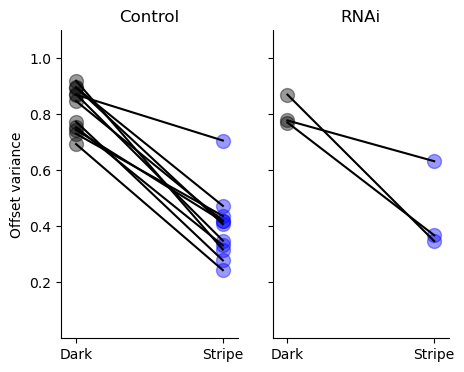

In [6]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=[5,4])

c_df = stats_df_plot.loc[stats_df_plot['rnai']=='control']
ax[0].set_title('Control')
ax[0].plot([0,1], c_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[0].scatter(np.zeros((c_df.shape[0],)), c_df['offset_var_dark'], color='black', alpha=.4, s=100)
ax[0].scatter(np.ones((c_df.shape[0],)), c_df['offset_var_closed_loop'], color='blue', alpha=.4, s=100)

rnai_df = stats_df_plot.loc[stats_df_plot['rnai']=='rnai']
ax[1].set_title('RNAi')
ax[1].plot([0,1], rnai_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[1].scatter(np.zeros((rnai_df.shape[0],)), rnai_df['offset_var_dark'], color='black', alpha=.4, s=100)
ax[1].scatter(np.ones((rnai_df.shape[0],)), rnai_df['offset_var_closed_loop'], color='blue', alpha=.4, s=100)



for _ax in ax:
    _ax.set_ylim([0.0,1.1])
    _ax.set_xlim([-.1,1.1])
    _ax.set_yticks([.2,.4,.6,.8,1.])

    _ax.set_xticks([0, 1], labels=['Dark', 'Stripe'])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    
ax[0].set_ylabel('Offset variance')


# fig.savefig(figfolder / 'offset_var_summary.pdf', format='pdf')

In [7]:
def get_ts(pp, coef = 0):
    y = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = True)
    heading = np.angle(np.exp(1j*(-1*pp.voltage_recording_aligned[' Heading'].to_numpy()-np.pi)))
    bar_vis_mask = np.abs(heading)<2.64
   
    y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y-1, 1, axis=-1),.5,axis=1, mode='wrap')
    
    
    n_rois = y.shape[1]
    x_f,y_f = st2p.utilities.pol2cart(y[-1,:,:] ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
    rho, phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))


    _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

    
    return {'heading': heading,
            'bar_vis_mask': bar_vis_mask,
            'y': y,
            'y_sm': y_sm,
            'rho': rho,
            'phi': phi,
            'offset': offset}


def align_to_heading(ts):
    heading_bins = np.linspace(-np.pi, np.pi, num=17)
    heading_dig = np.digitize(ts['heading'], heading_bins)-1

    y_h_aligned = np.zeros([1,*ts['y'].shape[1:]])
    for ind in range(ts['heading'].shape[0]):
        y_h_aligned[-1,:,ind] = np.roll(ts['y'][-1,:,ind], -heading_dig[ind]-8)
       
       
        
    y_h_aligned_z = np.zeros((1,16,16))
    for b in range(16):
        mask = heading_dig==b
        y_h_aligned_z[:,:,b] = y_h_aligned[:,:,mask].mean(axis=-1)
    
    
    return heading_bins, y_h_aligned, y_h_aligned_z

def load_pp(row):
    if row['rnai']==0:
        outdir = pathlib.PurePath( basedir / 'control' / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')    
    elif row['rnai']==1:
        outdir = pathlib.PurePath( basedir / 'rnai' / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')

    if pathlib.Path(outdir).exists():
        return st2p.preprocessing.EBImagingSession.from_file(outdir)
    else:
        return None


[[ 1.97479804  2.09705463]
 [-2.92294606 -2.4977088 ]
 [-2.45484445 -2.53639658]
 [ 0.58739139  0.33957678]
 [-0.94029663 -2.08361453]
 [ 1.48366667  1.43211239]
 [ 1.31919821 -0.53052029]
 [ 2.71159489  2.59673293]
 [ 2.60018009 -2.27775051]
 [-2.41830425 -2.62871789]
 [-3.12276884 -3.09234076]]
[14.] [0.1015625]


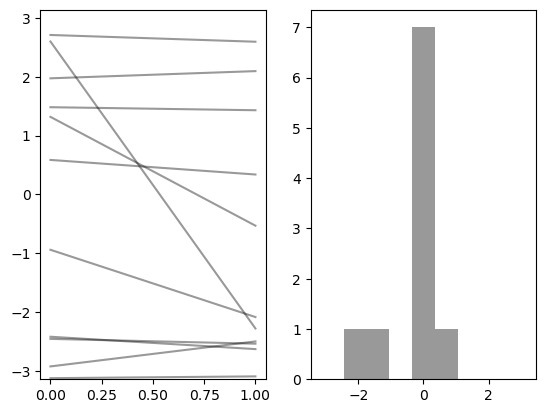

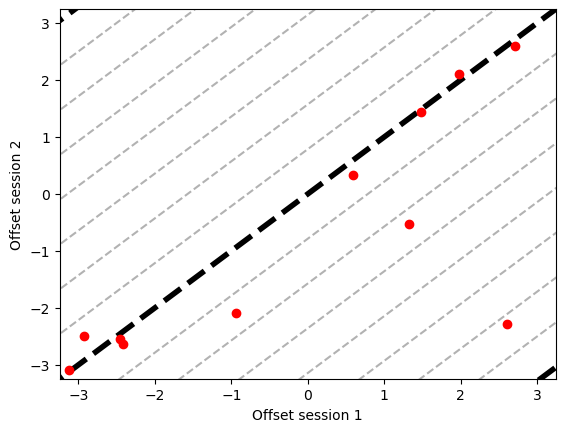

In [8]:
fig, ax = plt.subplots(1,2, sharey = False)

ctrl_fly_ids = [f for f in fly_ids if "control" in f]

offsets = []
for r, fly in enumerate(ctrl_fly_ids):
    offset_dict={}
    fly_df = sess_df.loc[sess_df['fly_id']==fly]
    if np.sort(fly_df['closed_loop'].to_numpy()).tolist() == [0,1,2]: # all sessions exist
        for _, row in fly_df.iterrows():
            offset_dict[row['closed_loop']]= sp.stats.circmean(get_ts(load_pp(row))['offset']) - np.pi
    else:
        pass
    
    ax[0].plot([0,1], [offset_dict[1], offset_dict[2]], color='black', alpha=.4)
    offsets.append([offset_dict[1], offset_dict[2]])
    
offsets = np.array(offsets)
print(offsets)

ax[0].set_ylim([-np.pi, np.pi])
ax[1].hist(np.diff(offsets,axis=-1), np.linspace(-np.pi, np.pi, num=10), color='black', alpha=.4)
t,p = sp.stats.wilcoxon(np.diff(offsets,axis=-1))
print(t,p)

fig, ax = plt.subplots()
ax.scatter(offsets[:,0], offsets[:,1], color='red')

x = np.linspace(-6,6)
ax.plot(x,x, 'k--',linewidth=4, zorder=-10)
ax.plot(x,x-2*np.pi, 'k--', linewidth=4, zorder=-10)
ax.plot(x,x+2*np.pi, 'k--', linewidth=4, zorder=-10)
for dx in np.arange(np.pi/4, 2*np.pi, np.pi/4):
    # y = x-dx
    ax.plot(x, x-dx, 'k--', alpha=.3)
    ax.plot(x, x+dx, 'k--', alpha=.3)
    # ax.plot([-np.pi+x, np.pi], [-np.pi, np.pi-x], 'k--', alpha=.3)
    # ax.plot([-np.pi, np.pi-x], [-np.pi+x, np.pi], 'k--', alpha=.3)
    
ax.set_xlabel('Offset session 1')
ax.set_ylabel('Offset session 2')
# ax.fill_between([-np.pi+np.pi/4, np.pi],[-np.pi, np.pi-np.pi/4], y2=[-np.pi, -np.pi],
#                alpha=.3, edgecolor='k',linewidth=1,hatch='.', facecolor='none')

# ax.fill_between([-np.pi+np.pi/2, np.pi],[-np.pi, np.pi-np.pi/2], y2=[-np.pi, -np.pi],
#                 alpha=.3, edgecolor='k',linewidth=1, color='black')


# ax.fill_between([-np.pi, np.pi-np.pi/2],[-np.pi+np.pi/2, np.pi], y2=[np.pi, np.pi],
#                 alpha=.3, edgecolor='k',linewidth=1,hatch='.', facecolor='none')
ax.set_xlim([-np.pi-.1, np.pi+.1])
ax.set_ylim([-np.pi-.1, np.pi+.1])
fig.savefig(figfolder / 'offset1_v_offset2.pdf')


06_01_2025_fly1_control
06_01_2025_fly2_control
07_01_2025_fly1_control
07_01_2025_fly2_control
09_01_2025_fly1_control
09_01_2025_fly3_control
09_01_2025_fly4_control
11_01_2025_fly3_control
17_01_2025_fly2_control
04_02_2025_fly5_control
04_02_2025_fly6_control


/tmp/ipykernel_3555860/2760539150.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3,2,figsize=(15,6),sharey=True)


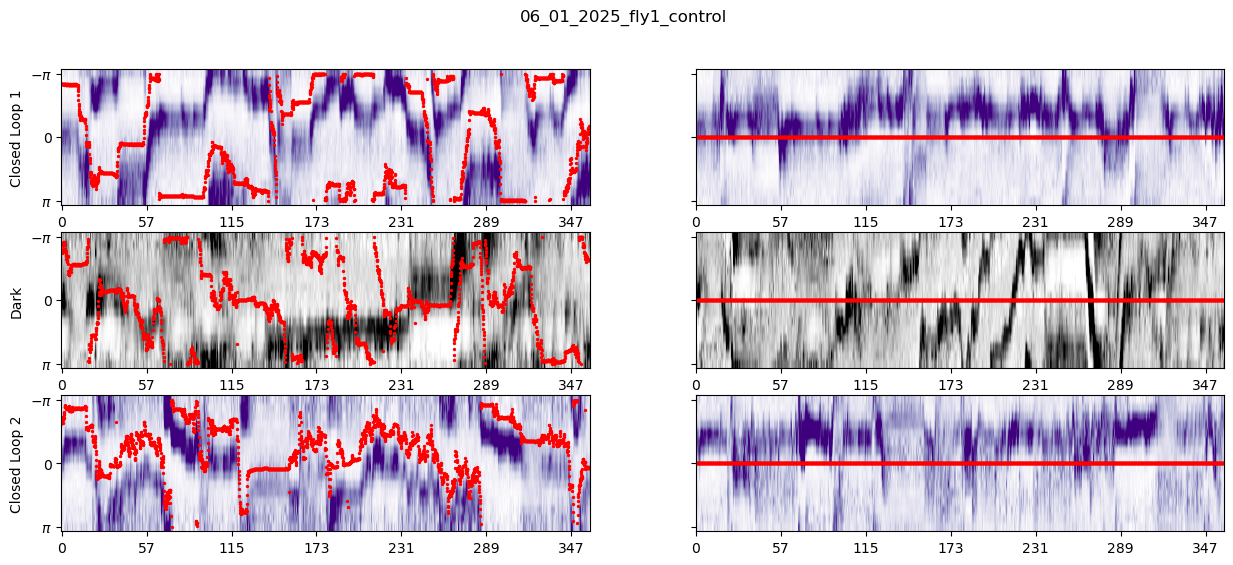

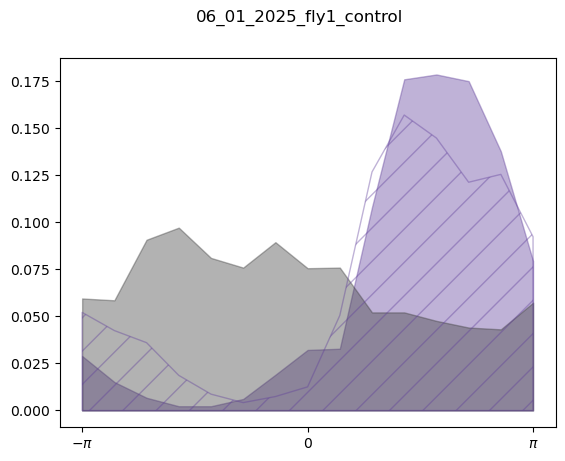

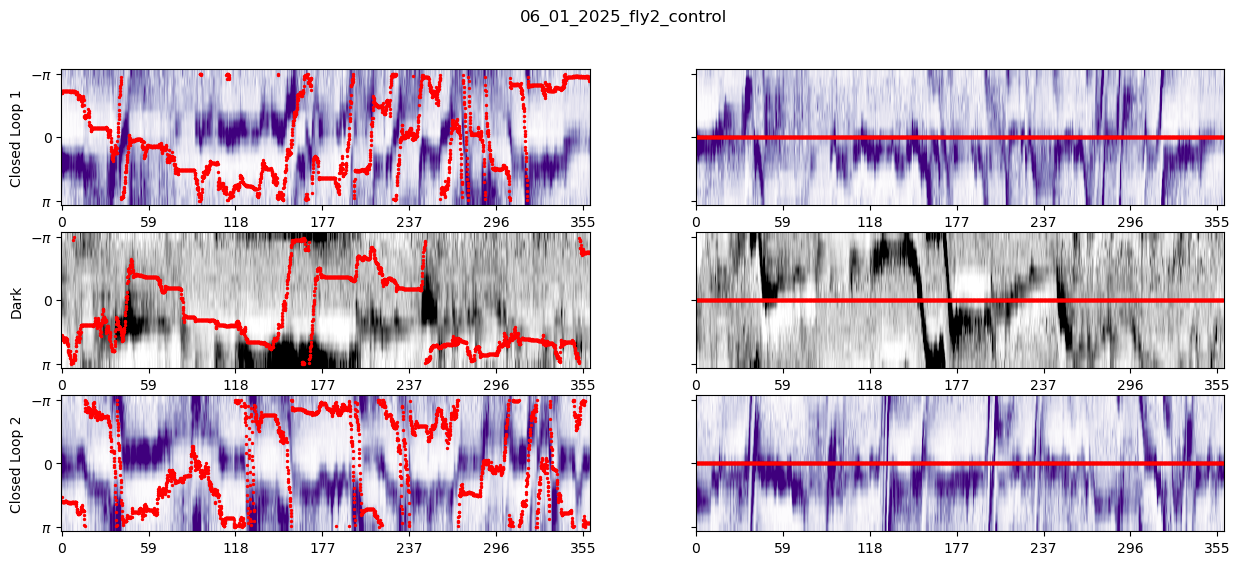

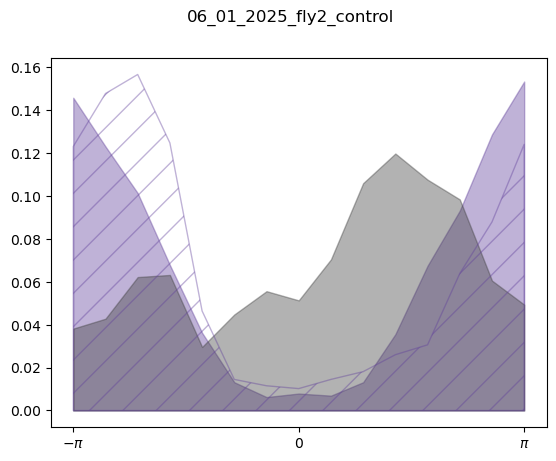

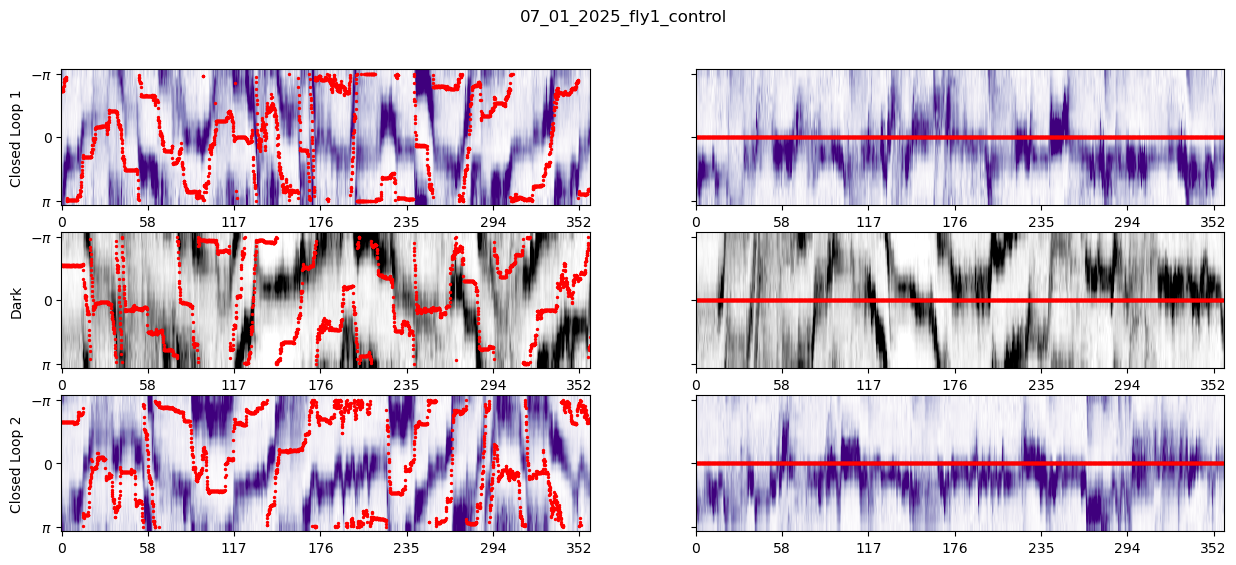

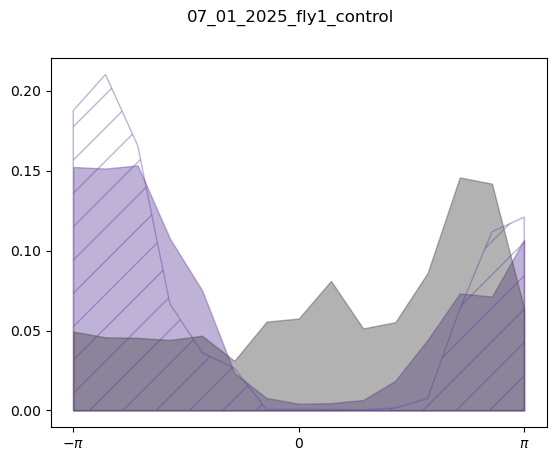

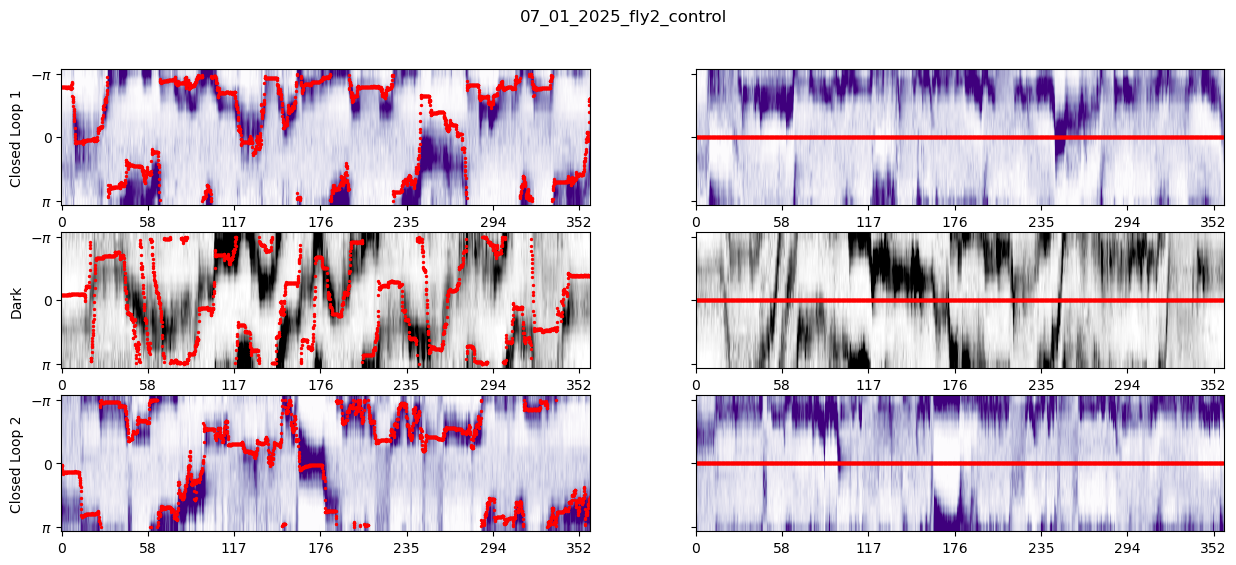

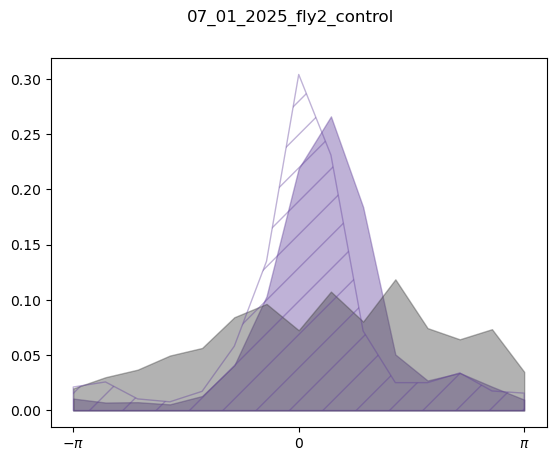

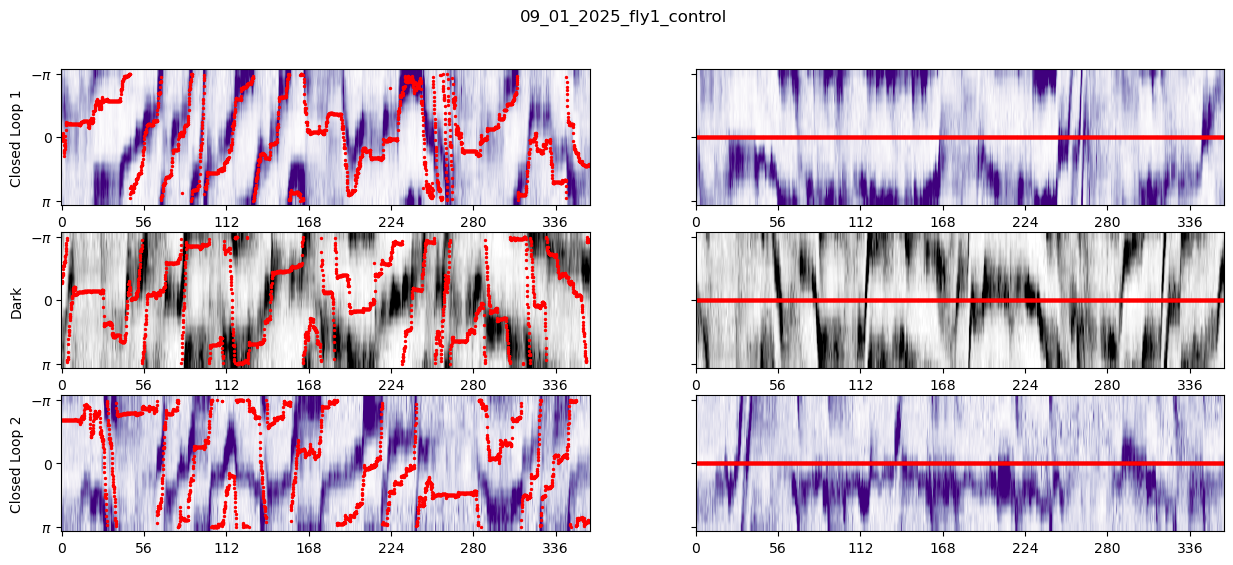

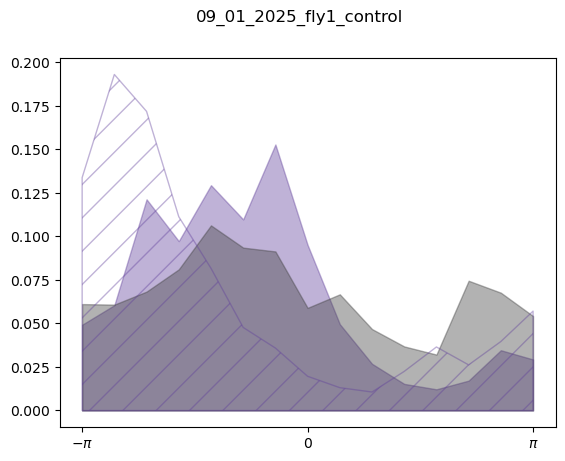

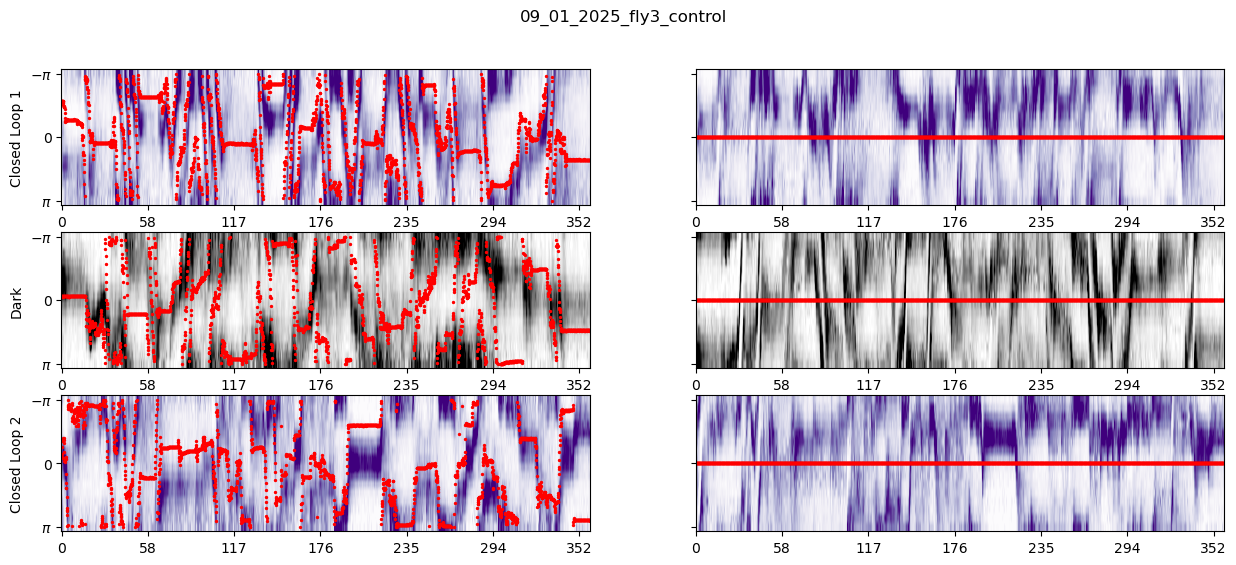

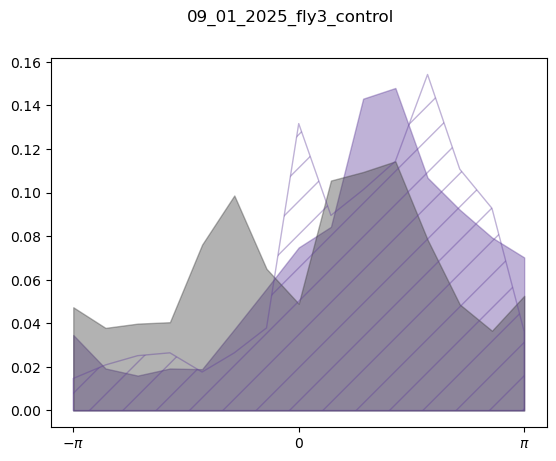

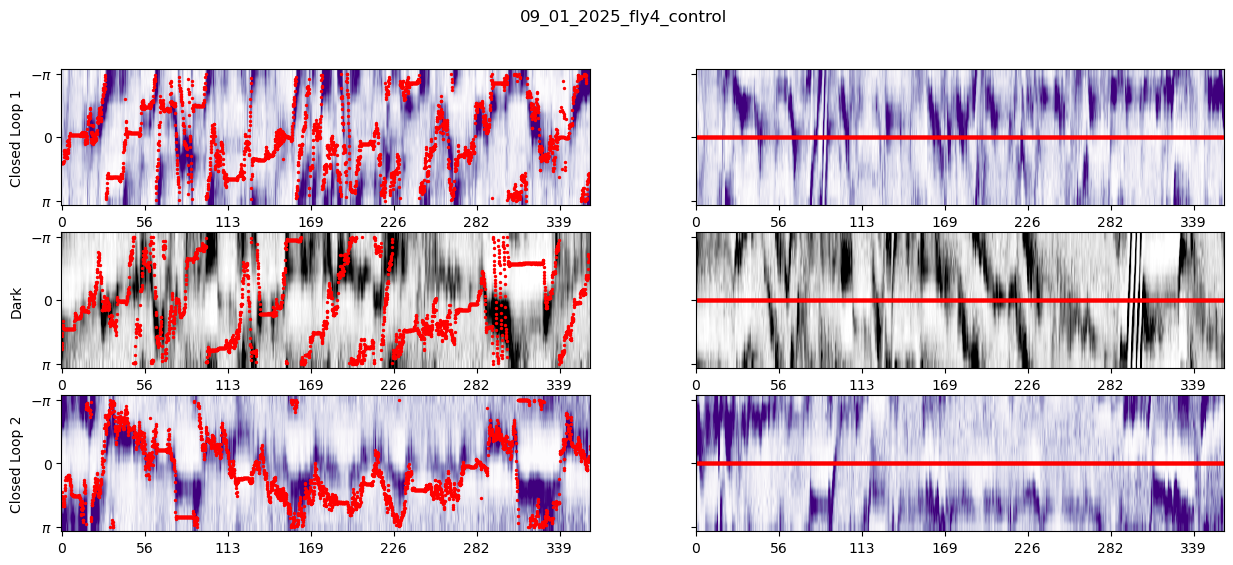

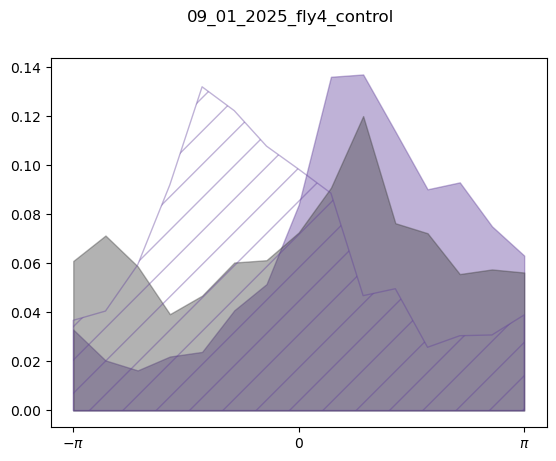

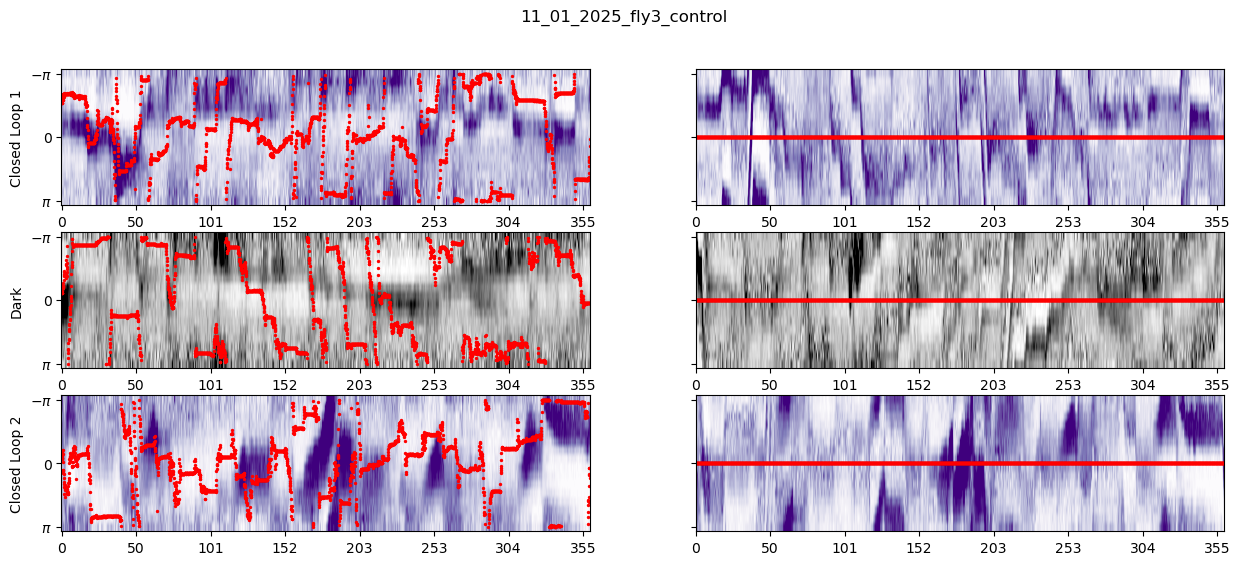

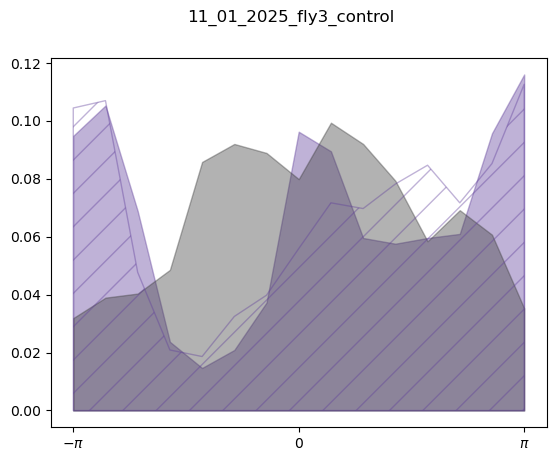

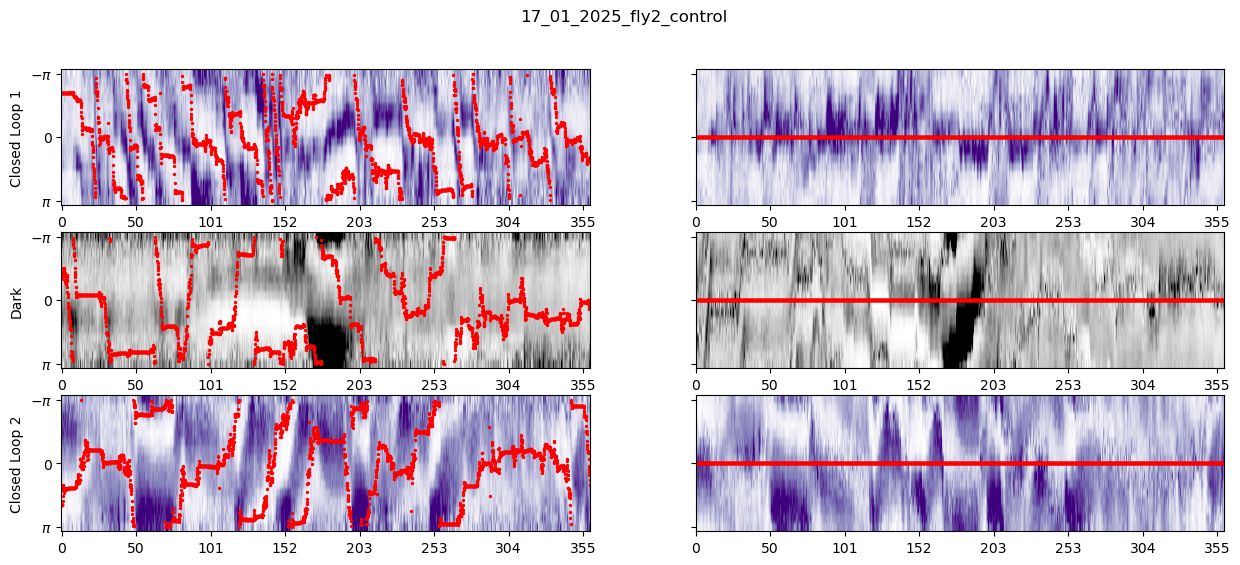

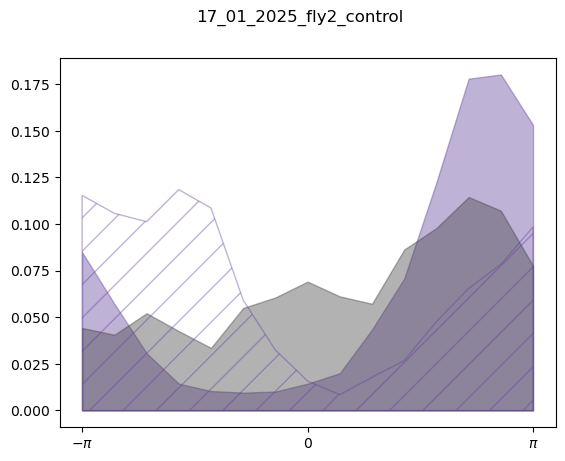

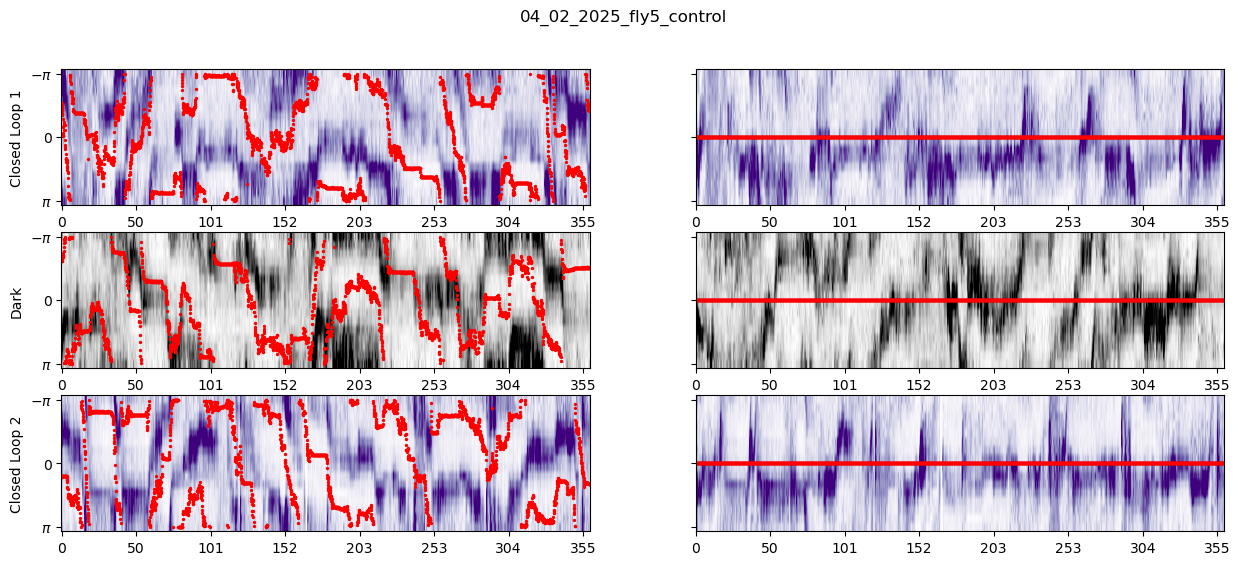

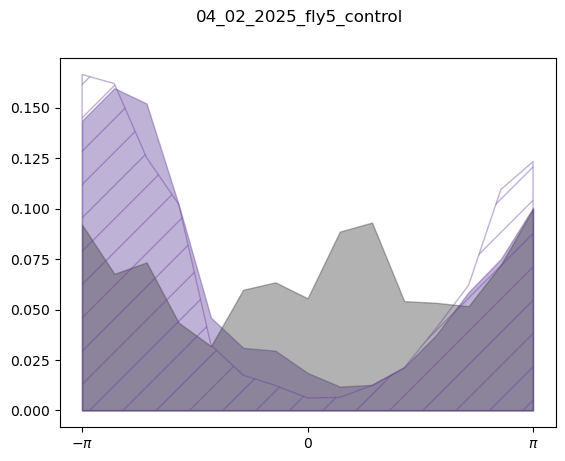

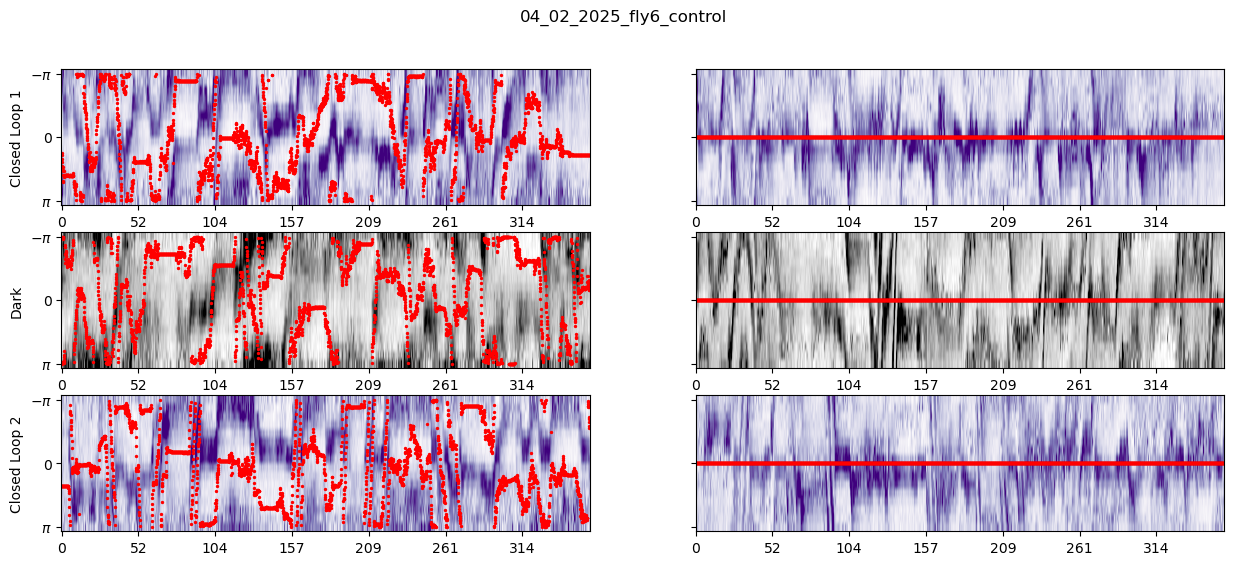

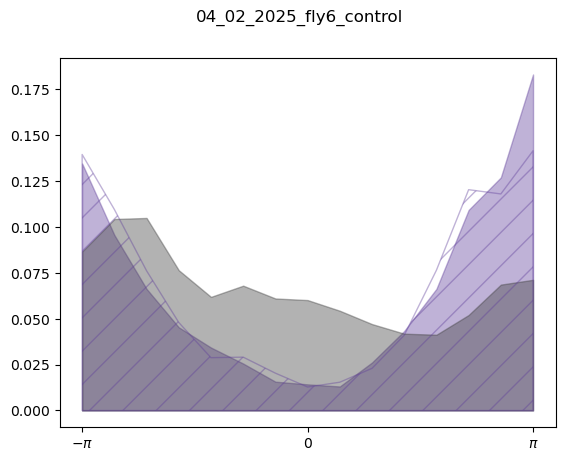

In [9]:
eg_figfolder = figfolder / 'example_sessions'
eg_figfolder.mkdir(parents=True, exist_ok=True)

remap_sess_df = sess_df
flies = remap_sess_df['fly_id'].unique()


bins = np.arange(16)
edges = np.linspace(-np.pi, np.pi, num=16)
window = slice(0,10000)
centers = (edges[:-1]+edges[1:])/2
    
for fly in ctrl_fly_ids:
    _df = sess_df.loc[sess_df['fly_id']==fly]
    
    if (_df.shape[0]>=3):
        print(fly)

        fig, ax = plt.subplots(3,2,figsize=(15,6),sharey=True)
        fig_hist, ax_hist = plt.subplots()

        ##
        cl0 = _df.loc[_df['closed_loop']==1].iloc[0]
    
        # print(baseline.iloc[0])
        outdir = pathlib.PurePath( basedir / 'control' / cl0['date'] / cl0['fly'] / cl0['session'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        ts = get_ts(pp,coef=0)

        h = ax[0,0].imshow(ts['y'][-1,:,window]-1,aspect='auto',cmap='Purples',
                           vmin=np.percentile(ts['y'][-1,:,:]-1,5), 
                           vmax=np.percentile(ts['y'][-1,:,:]-1,95))

        heading = 15*(np.angle(np.exp(1j*(ts['heading']-np.pi)))+np.pi)/2/np.pi
        t = np.arange(ts['heading'].shape[-1])
        ax[0,0].scatter(t, heading, s=2, color='red')

        # time = 
        time = np.array(pp.metadata['frame_times']).mean(axis=-1)
        ax[0,0].set_xticks(t[::500],labels=[int(_t) for _t in time[::500]])
        ax[0,0].set_yticks([0, 7.5, 15], labels=[r'$-\pi$', 0, r'$\pi$'])


        heading_bins, y_h_aligned, y_h_aligned_z = align_to_heading(ts)
        h = ax[0,1].imshow(y_h_aligned[-1,:,window]-1, aspect='auto',cmap='Purples', 
                           vmin=np.percentile(ts['y'][-1,:,:]-1,5), 
                           vmax=np.percentile(ts['y'][-1,:,:]-1,95))
        ax[0,1].scatter(t, 7.5*np.ones_like(t), color='red',s=2)

        ax[0,1].set_xticks(t[::500],labels=[int(_t) for _t in time[::500]])
        
        ax[0,0].set_ylabel('Closed Loop 1')
        hist, _ = np.histogram(ts['offset'], bins = np.linspace(-np.pi,np.pi,num=16))
        hist = np.roll(hist,-8)
        ax_hist.fill_between(centers, hist/hist.sum(), alpha=.4, color=plt.cm.Purples(.8))
        ax_hist.set_xticks([centers[0], 0, centers[-1]], labels=[r'$-\pi$', 0, r'$\pi$'])
        
        
#     

        dark = _df.loc[_df['closed_loop']==0].iloc[0]
    
        outdir = pathlib.PurePath( basedir / 'control' / dark['date'] / dark['fly'] / dark['session'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        ts = get_ts(pp,coef=0)

        h = ax[1,0].imshow(ts['y'][-1,:,window]-1,aspect='auto',cmap='Greys',
                           vmin=np.percentile(ts['y'][-1,:,:]-1,5), 
                           vmax=np.percentile(ts['y'][-1,:,:]-1,95))

        heading = 15*(np.angle(np.exp(1j*(ts['heading']-np.pi)))+np.pi)/2/np.pi
        t = np.arange(ts['heading'].shape[-1])
        ax[1,0].scatter(t, heading, s=2, color='red')

        # time = 
        time = np.array(pp.metadata['frame_times']).mean(axis=-1)
        ax[1,0].set_xticks(t[::500],labels=[int(_t) for _t in time[::500]])
        ax[1,0].set_yticks([0, 7.5, 15], labels=[r'$-\pi$', 0, r'$\pi$'])


        heading_bins, y_h_aligned, y_h_aligned_z = align_to_heading(ts)
        h = ax[1,1].imshow(y_h_aligned[-1,:,window]-1, aspect='auto',cmap='Greys', 
                           vmin=np.percentile(ts['y'][-1,:,:]-1,5), 
                           vmax=np.percentile(ts['y'][-1,:,:]-1,95))
        ax[1,1].scatter(t, 7.5*np.ones_like(t), color='red',s=2)
        ax[1,1].set_xticks(t[::500],labels=[int(_t) for _t in time[::500]])
        
        ax[1,0].set_ylabel('Dark')
        hist, _ = np.histogram(ts['offset'], bins = np.linspace(-np.pi,np.pi,num=16))
        hist = np.roll(hist,-8)
        ax_hist.fill_between(centers, hist/hist.sum(), alpha=.4, color=plt.cm.Greys(.8))
        ax_hist.set_xticks([centers[0], 0, centers[-1]], labels=[r'$-\pi$', 0, r'$\pi$'])
        
#         
        cl1 = _df.loc[_df['closed_loop']==2].iloc[0]
    
        # print(baseline.iloc[0])
        outdir = pathlib.PurePath( basedir / 'control' / cl1['date'] / cl1['fly'] / cl1['session'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        ts = get_ts(pp,coef=0)

        h = ax[2,0].imshow(ts['y'][-1,:,window]-1,aspect='auto',cmap='Purples',
                           vmin=np.percentile(ts['y'][-1,:,:]-1,5), 
                           vmax=np.percentile(ts['y'][-1,:,:]-1,95))

        heading = 15*(np.angle(np.exp(1j*(ts['heading']-np.pi)))+np.pi)/2/np.pi
        t = np.arange(ts['heading'].shape[-1])
        ax[2,0].scatter(t, heading, s=2, color='red')

        # time = 
        time = np.array(pp.metadata['frame_times']).mean(axis=-1)
        ax[2,0].set_xticks(t[::500],labels=[int(_t) for _t in time[::500]])
        ax[2,0].set_yticks([0, 7.5, 15], labels=[r'$-\pi$', 0, r'$\pi$'])


        heading_bins, y_h_aligned, y_h_aligned_z = align_to_heading(ts)
        h = ax[2,1].imshow(y_h_aligned[-1,:,window]-1, aspect='auto',cmap='Purples', 
                           vmin=np.percentile(ts['y'][-1,:,:]-1,5), 
                           vmax=np.percentile(ts['y'][-1,:,:]-1,95))
        ax[2,1].scatter(t, 7.5*np.ones_like(t), color='red',s=2)

        ax[2,1].set_xticks(t[::500],labels=[int(_t) for _t in time[::500]])
        
        ax[2,0].set_ylabel('Closed Loop 2')
        hist, _ = np.histogram(ts['offset'], bins = np.linspace(-np.pi,np.pi,num=16))
        hist = np.roll(hist,-8)
        ax_hist.fill_between(centers, hist/hist.sum(), alpha=.4, color='none', hatch='/', edgecolor=plt.cm.Purples(.8))
        ax_hist.set_xticks([centers[0], 0, centers[-1]], labels=[r'$-\pi$', 0, r'$\pi$'])
        
        fig.suptitle(fly)
        fig_hist.suptitle(fly)

        fig.savefig(eg_figfolder / f"{fly}_heatmaps.pdf")
        fig_hist.savefig(eg_figfolder / f"{fly}_hist.pdf")